# X-ray Absorption Spectroscopy Simulation in the Time-Domain 

What will be the first industrially useful algorithm to run on a fault-tolerant quantum computer? This open question is one of the main focuses for our research teams at Xanadu. A potential answer to this question is simulations of X-ray absorption spectroscopy, which can be used in a workflow to identify structural degradation mechanisms in materials candidates for battery designs. This demo will show you how to implement an optimized version of a simulation algorithm developed in the paper "Fast simulations of X-ray absorption spectroscopy for battery materials on a quantum computer" [Fomichev:2025] in PennyLane. 

First, we will discuss why simulating X-ray absorption spectroscopy is useful, and why it is a promising application for early quantum computers. Then we will explain the main steps in the simulation algorithm, and how to implement a simplified version in PennyLane.

We will be using concepts that were introduced in other PennyLane demos, such as [utilizing PySCF with PennyLane](https://pennylane.ai/qml/demos/tutorial_qchem_external), [initial state preparation of molecules](https://pennylane.ai/qml/demos/tutorial_initial_state_preparation), and building [compressed double-factorized Hamiltonians](https://pennylane.ai/qml/demos/tutorial_how_to_build_compressed_double_factorized_hamiltonians). If you haven't checked out those demos yet, it might be best to do so and then come back here.

## Why simulate X-ray absorption spectroscopy?
Lithium-excess materials are transition metal oxides that have been engineered to accomodate extra Lithium atoms in their structural composition, designed as a candidate for use in battery cathodes. However, repeated charge-discharge cycles can alter the structure and reduce performance. One can study these degraded materials using X-ray absorption spectroscopy, which directly probes local structure by exciting tightly bound core electrons. This can be used to identify oxidation states in materials, because different elements and their oxidation states will absorb photons of different energies. However, this requires reference spectra for each expected degredation outcome in order to determine the composition of structures present in the material. We call this "spectral fingerprinting", where the observed spectrum can be matched to combinations of spectra from small clusters. 

![alt text](_static/demonstration_assets/xas/fingerprinting.gif)

Figure X: *How simulation of X-ray absorption spectra can enable identification of oxidation states in candidate battery materials.* Spectral fingerprinting can be used to identify constituent structures of a material by decomposing experimental spectra into components calculated via simulation on a quantum computer.

Simulating these spectra is a difficult task for classical computers -- the highly correlated excited states are difficult to compute classically, particularly for transition metals. However, the relatively small set of electronic orbitals needed to simulate these small clusters make this simulation task well suited for early quantum computers which will be limited in their number of qubits.

## Algorithm

### Absorption cross-section

In XAS experiments the absorption cross section as a function of the frequency of incident X-rays $\sigma_A(\omega)$ is measured for a material. This is related to the rate of absorption of X-ray photons of various energies. For our situation, the electrons in the molecular cluster start in a ground molecular state $|I\rangle$ with energy $E_I$, and will be coupled to an excited state $|F\rangle$ with energy $E_F$ through the action of the dipole operator $\hat m_\rho$, which represents the effect of the radiative field, where $\rho$ is any of the Cartesian directions $\{x,y,z\}$. 

The absorption cross section is given by

$$ \sigma_A(\omega) = \frac{4 \pi}{3 \hbar c} \omega \sum_{F \neq I}\sum_{\rho=x,y,z} \frac{|\langle F|\hat m_\rho|I \rangle|^2 \eta}{((E_F - E_I)-\omega)^2 + \eta^2}\,, $$

where $c$ is the speed of light, $\hbar$ is Plank's constant, and $\eta$ is the line broadening which here is set by the experimental resolution of the spectroscopy, and is typically around $1$ eV. In general, it could also be related to the lifetime of the excited states. 

![alt text](_static/demonstration_assets/xas/spectrum_sketch.png)

Figure X: *Example X-ray absorption spectrum.* Illustration of how the peak positions $E_F - E_i$, widths $\eta$ and amplitudes $|\langle F | \hat m_\rho | I \rangle|^2$ determine the spectrum.

The goal is to implement a quantum algorithm that can calculate this spectrum. Howevever, instead of computing the energy differences and state overlaps directly, we will be simulating the system in the time domain, and then using a Fourier transform to obtain the spectrum in the frequency domain.

### Quantum algorithm in the time-domain
Given $\hat m_\rho |I\rangle$, we can use a mathematical trick called a *frequency-domain Green's function* to understand how to determine the absorption cross section. We can write the cross section as the imaginary part of the following Green's function

$$\mathcal{G}_\rho(\omega) = \langle I|\hat m_\rho \frac{1}{\hat H -E_I -\omega +i\eta} \hat m_\rho |I\rangle\,.$$

Using a resolution of identity of the final states and simplifying, we end up with

$$ \mathrm{Im}(\mathcal{G_\rho(\omega)}) = -\sum_{F\neq I} \frac{|\langle F|\hat m_\rho|I\rangle|^2\eta}{(E_F- E_I -\omega)^2 +\eta^2} + \frac{|\langle I|\hat m_\rho|I\rangle|^2\eta}{\omega^2 +\eta^2}\,. $$

The second term is also zero if we centre the frame of reference for our molecular orbitals at the nuclear-charge weighted centre for our molecular cluster of choice.

There are methods for determining this frequency-domain Green's function directly [Fomichev:2024], however, our algorithm will instead aim to calculate the discrete-time *time-domain Green's function* (clock emoji x2) $\tilde G(t_j)$ at times $t_j=j\tau$ where $j$ is the index and $\tau$ is the time interval. $G_\rho(\omega)$ can then be calculated classically through the time-domain Fourier transform

$$ G_\rho(\omega) = \frac{\tau}{2\pi} \sum_{j=-\infty}^\infty e^{-\eta |t_j|} \tilde G(t_j) e^{i\omega t_j}\,, $$

where $\tau \sim \mathcal{O}(||\hat H||^{-1})$ is chosen so that all eigenstates $|F\rangle$ of relevance are rescaled into the range $[-\pi, \pi)$. That is, we need the resolution of our time-evolution to be small enough to resolve the largest frequency components that we are interested in, which correspond to the final states with the largest energy. In practice, this is not the largest eigenvalue of $\hat H$, but simply the largest energy we want to show in the spectrum.

The time-domain Green's function can be determined using the expectation value of the time evolution operator (normalized)

$$ \tilde G_\rho(t_j) = \frac{\langle I|\hat m _\rho e^{- i\hat H t_j} \hat m_\rho |I\rangle}{|| \hat m_\rho |I\rangle ||^2}\,. $$

A Hadamard test circuit on the time evolution unitary can be used to measure the expectation value for each time $t_j$ by repeating a number of times $N$ and taking the mean of the results. 

The circuit we will construct to determine the expectation values is shown below. It has three main components: first, the state $\hat m_\rho |I\rangle$ is prepared in the quantum register, and an auxilliary qubit is prepared for controlled time evolution; second, the state is evolved under the electronic Hamiltonian; finally the time-evolved state is measured to obtain statistics for the expectation value.

![alt text](_static/demonstration_assets/xas/global_circuit.png)


Figure X: *Circuit for XAS simulation*. The algorithm is ultimately a Hadamard test circuit, and we divide the steps of this into three components. 

To obatin the absorption cross section, we repeat the above measurement for a number of shots $N$ for each time $t_j$ for $j \in [0, j_\mathrm{max}]$ to obtain the time-domain Green's function $\tilde G(t_j)$. Fourier transforming $\tilde G(t_j)$ gives the frequency-domain Green's function $G(\omega)$, which is related to the absorption spectrum.

## Implementation
Let's look at how to implement these steps in PennyLane. We will make extensive use of the `qml.qchem` module, as well as modules from PySCF. 

For this demo, we are going to use the very simple $H_2$ molecule. We will implement some, but not all of the optimizations detailed in [Fomichev:2025]. The other optimizations will be discussed at the end.

### Initial state preparation
If you haven't, check out the demo "Initial state preparation for quantum chemistry" **[link]**. 

We start by creating our molecule object using the Gaussian type orbitals module `pyscf.gto`, and obtaining the reduced Hartree-Fock molecular orbitals with the self-consistent field methods `pyscf.scf`.

In [1]:
from pyscf import gto, scf
import numpy as np

# Create a Mole object.
r = 0.71  # Bond length in Angstrom.
symbols = ["H", "H"]
geometry = np.array([[0.0, 0.0, -r/2], [0.0, 0.0, r/2]])
basis = "631g"
mol = gto.Mole(atom=zip(symbols, geometry), basis=basis, symmetry=None)
mol.build(verbose=0)

# Get the molecular orbitals.
hf = scf.RHF(mol)
hf.run(verbose=0)
n_orb = hf.mol.nao  # Number of molecular orbitals.

To make sure that $\langle I|\hat m_\rho|I\rangle$ is zero, we can shift the `Mole` object's coordinates such that the nuclear-charge-weighted centre is at the origin. Note this is true from our construction, since the geometry was defined to be symmetric about the origin, but I want to emphasize the importance of this condition.

In [2]:
# Guarantee nuclear charge centre is at the origin.
charges, coords = (hf.mol.atom_charges(), hf.mol.atom_coords())
nuc_charge_center = np.einsum("z,zx->x", charges, coords) / charges.sum()
print("Initial nuclear charge centre", nuc_charge_center)
hf.mol.set_common_orig_(nuc_charge_center)
print("Shifted nuclear charge centre", nuc_charge_center)

Initial nuclear charge centre [0. 0. 0.]
Shifted nuclear charge centre [0. 0. 0.]


Next we will use the configuration interaction singles and doubles methods from `pyscf.ci` to solve for the ground state of the molecule. We will then import the state into PennyLane using `qml.qchem.import_state`.

In [3]:
from pyscf import ci
import pennylane as qml

myci = ci.CISD(hf).run(verbose=0)

# Ground state energy.
E_i = myci.e_tot
print("E_i: ", np.round(E_i, 4), 'Ha')

# Ground state wavefunction.
wf_ci = qml.qchem.import_state(myci, tol=1e-5)

E_i:  -1.1508 Ha


### Dipole operator action

**Note we need anti-symmetry and spin in the following discussion, perhaps added in at the end.**

Let's discuss how the dipole operator acts on the initial state. The dipole operator $\hat m = -q \cdot \hat r$ will only affect the spatial component of the wavefunction -- it does not care about spin. To determine the action of the dipole operator in the molecular orbital basis, we use two resolutions of identity to introduce the molecular orbital wavefunctions $|k\rangle$

$$ \hat m_\rho = -q \cdot \hat r= -q \sum_{ij} |i\rangle \langle i| \hat r |j\rangle \langle j|\,. $$

Then, we simplify by noticing that $|i\rangle \langle j| = c_i^\dagger c_j$ where $c_k^{(\dagger)}$ is the annihilation (creation) operator for orbital $k$. That gives us

$$ \hat m = -q \sum_{ij} \langle i|\hat r |j\rangle c_i^\dagger c_j\,. $$

To calculate the matrix elements $\langle i|\hat r |j\rangle$, we again insert sums over basis states, this time in the position basis. The matrix elements are then integrals of orbitals 

$$ \langle i|\hat r |j\rangle = \int d^3r' d^3r'' \langle i|r'\rangle \langle r' |\hat r | r'' \rangle \langle r'' | j \rangle = \int d^3r' d^3r'' \phi_i(r') r \phi_j^*(r'') \,, $$

where $\phi_k(r)$ are the orbital spatial wavefunctions. 

**Explain PennyLane `dipole_moment` implementation.**

In [4]:
# Create qml Molecule object.
mole = qml.qchem.Molecule(symbols, geometry, basis_name='6-31g', unit='angstrom')

rho = 2  # z direction
m_rho = qml.qchem.dipole_moment(mole)()[rho]
dipole_matrix_rho = qml.matrix(m_rho)

wf_dip = dipole_matrix_rho.dot(wf_ci)
dip_norm = np.linalg.norm(wf_dip)
wf_dip = wf_dip/dip_norm

Let's prepare the circuit that will initialize our qubit register with this state. We will need $n_\mathrm{orb}$ wires to load the full state, and we'll need one auxiliary qubit for the measurement circuit, which we will prepare as the 0 wire with an applied Hadamard gate.

In [5]:
import pennylane as qml

device_type = "lightning.qubit"

# Initialization circuit for m_rho|I>.
dev_prop = qml.device(device_type, wires=int(2*n_orb) + 1, shots=None)

@qml.qnode(dev_prop)
def initial_circuit(wf):
    # Dipole wavefunction preparation.
    qml.StatePrep(wf, wires=dev_prop.wires.tolist()[1:])
    qml.Hadamard(wires=0)
    return qml.state()

### Molecular Hamiltonian

Our electronic Hamiltonian is

$$ H = E + \sum_{p,q=1}^N \sum_{\gamma\in\{\uparrow,\downarrow\}} (p|\kappa|q) a^\dagger_{p\gamma}a_{q\gamma} + \frac12 \sum_{p,q,r,s=1}^N\sum_{\gamma,\beta\in\{\uparrow,\downarrow\}} (pq|rs) a^\dagger_{p\gamma}a_{q\gamma} a^\dagger_{r\beta}a_{s\beta} \,, $$

where $a^{(\dagger)}_{p\gamma}$ is the annihilation (creation) operator for a molecular orbital $p$ and spin $\gamma$, $E$ is the core constant, $N$ is the number of spatial orbitals, and $(p|\kappa|q)$ and $(pq|rs)$ are the one- and two-electron integrals, respectively **[ref]**. 

Luckily, the core constant and the one- and two-electron integrals can be computed in PennyLane using `qml.qchem.integrals`. We will have to convert these to chemist's notation **[ref]**.

In [23]:
# Compute core constant and one- and two-electron integrals.
core_constant, one, two = qml.qchem.electron_integrals(mole)()

# Re-write in Chemist's notation.
two_chemist = np.einsum('prsq->pqrs', two)
one_chemist = one - np.einsum('pqrr->pq', two) / 2
core_constant = core_constant[0]

Go read the demo "How to build compressed double-factorized Hamiltonians" **[link]** if you haven't, because that is exactly what we are going to do!

To time evolve our state with a Trotter product formula, we are going to restructure our one and two-electron integral terms into *fragments* labelled by integer $\ell$, each with a single-particle basis for which they are diagonal. The time-evolution of each fragment will then require rotating into that diagonalizing basis, applying the fragment, and rotating back.

#### One-electron terms

For the one-body terms, which we will label as fragment $\ell=0$, we can simply diagonalizing the terms.

$$ (p|\kappa|q) = \sum_k U_{pk}^{(0)}Z_{kk}^{(0)}U_{qk}^{(0)}\,, $$

where $Z_{kk}^{(0)}$ are the eigenvalues and $U_{pq}^{(0)}$ are the orthogonal matrix of eigenvectors. We can also realize that the eigenvectors $U_{pq}^{(0)}$ can transform the creation and annihilation operators in the one-body term to the $(0)$ basis. So, we can rewrite the one-body Hamiltonian term in the following way

$$ 
\begin{align}
&\quad\ \sum_{p,q=1}^N \sum_{\gamma\in\{\uparrow,\downarrow\}} \sum_k U_{pk}^{(0)}Z_{kk}^{(0)}U_{qk}^{(0)} a^\dagger_{p\gamma}a_{q\gamma} \\
&=\sum_{p,q=1}^N \sum_{\gamma\in\{\uparrow,\downarrow\}} \sum_k Z_{kk}^{(0)} \left(U_{pk}^{(0)} a^\dagger_{p\gamma}\right) \left(U_{qk}^{(0)} a_{q\gamma}\right) \\
&=\sum_{\gamma\in\{\uparrow,\downarrow\}} \sum_k Z_{kk}^{(0)} a^{(0)\dagger}_{k\gamma} a^{(0)}_{k\gamma}\,,
\end{align}
$$

where we now have the creation and annihilation operators acting in the $(0)$ basis. They also have the same subscripts, so $a_{k\gamma}^{(0)\dagger} a_{k\gamma}^{(0)} = n_{k\gamma}$ is the number operator, which can be implemented using Pauli operators by the Jordan-Wigner transformation $n_{k\gamma} = (1-\sigma_{z,k\gamma})/2$. 

Because our operators in now in the $(0)$ basis, we need away to rotate our state into the $(0)$ basis before applying the Puali operators. To do this, we use Thouless's theorem **[ref]**, which allows us to contrsuct a unitary $\mathbf{U^{(0)}}$ which will transform the initial many-body qubit state prepared in the computational basis in response to rotating the single-particle basis by $U_{pq}^{(0)}$,

$$ \mathbf{U^{(0)}} = \mathrm{exp}\left(\sum_{p,q}[\mathrm{log}\,U^{(0)}]_{pq}(a_p^\dagger a_q - a_q^\dagger a_p) \right)\,. $$

This operator can be decomposed into Givens rotations **[link]** and is implemented in PennyLane with `qml.BasisState`. The time evolution of the one-body term is then, for a time $t$

$$ 
\begin{align}
&\quad \mathrm{exp}\left(-it\sum_{p,q}^N\sum_{\gamma\in{\uparrow,\downarrow}}(p|\kappa|q) a_{p\gamma}^\dagger a_{q\gamma}\right) \\
&= \mathbf{U}^{(0)} \left[\prod_{k,\gamma} \mathrm{exp}\left(-i \frac{Z_{kk}^{(0)}}{2} \sigma_{z,k\gamma} t\right)\right]\left(\mathbf{U}^{(0)}\right) \mathrm{exp}\left(-i\sum_k \frac{Z_{kk}^{(0)}}{2} t\right)\,,
\end{align}
$$

where the last term is just a global phase. **Is there a sign error here?**


#### Two-electron terms

For the two-electron terms, we can use compressed double-factorization **[refs]** to approximate the two-electron integral tensor as

$$ (pq|rs) \approx \sum_{\ell=1}^L \sum_{j,k=1}^N U_{pj}^{(\ell)}U_{qj}^{(\ell)}Z_{jk}^{(\ell)}U_{rk}^{(\ell)}U_{sk}^{(\ell)}\,, $$

where $Z_{jk}^{(\ell)}$ are the entries of symmetric matrices $Z^{(\ell)}$ for each fragment $\ell$, and $U_{pq}^{(\ell)}$ are entries of orthogonal matrices. We solve for this approximate decomposition by minimizing the difference between the left- and right-hand side of the above equation. 

We can CDF the two-electron integrals using `qml`'s `qchem.factorize` function, with `compressed=True`. 

In [24]:
# Factorize hamiltonian, producing matrices.
_, Z, U = qml.qchem.factorize(two_chemist, compressed=True, num_factors=n_orb)

print("Shape of the factors: ")
print("two_chemist", two_chemist.shape)
print("U", U.shape)
print("Z", Z.shape)

# Compare factorized two-electron term to original.
approx_two_chemist = qml.math.einsum("tpk,tqk,tkl,trl,tsl->pqrs", U, U, Z, U, U)
# assert qml.math.allclose(two_chemist, approx_two_chemist, atol=1.5e-3)

Shape of the factors: 
two_chemist (4, 4, 4, 4)
U (4, 4, 4)
Z (4, 4, 4)


Note the first dimension of the matrices `U` and `Z` is the number of fragments we've used to approximate the two-electron terms.

To implement these terms in a time-evolution operator, we follow the same tricks we used above: re-write each fregment $\ell$ by rotating the creation and annihilation operators into the $(\ell)$ basis; use the Jordan-Wigner transform to implement the number operators as Pauli matrixes in the $(\ell)$ basis; and finally, use Thouless's theorem to find a unitary $\mathbf{U}^{(\ell)}$ that can transform our many-qubit state.

The resulting form of the Hamiltonian term is

$$ \frac18 \sum_\ell \sum_{(j,\beta) \neq (k, \gamma)}Z_{jk}^{(\ell)}\sigma_{z,j\beta}^{(\ell)}\sigma_{z,k\gamma}^{(\ell)} - \frac12 \sum_\ell \sum_{j,k,\gamma}Z_{jk}^{(\ell)}\sigma_{z,k\gamma}^{(\ell)} \,, $$

where the first term is two-qubit Pauli rotations, but the second are one-qubit Pauli rotations. These term arise after simplifying due to symmetries in the two-electron integral. They are often called the *one-electron correction* terms because we can group and diagonalize them together with the one-electron terms. This results in different $Z^{(0)}$ and $U^{(0)}$ then would be obtained from the procedure above, but the motification is easy to implement, as we will show below.

We add the one-electron correction to the one-electron integrals, and use `np.linalg.eigh` to diagonalize them into the matrix $Z^{(0)}$ and obtain the rotation matrices $U^{(0)}$.

In [25]:
# Calculate the one-electron correction.
Z_prime = np.stack([np.diag(np.sum(Z[i], axis=-1)) for i in range(Z.shape[0])], axis=0)
one_electron_correction = np.einsum('tpk,tkk,tqk->pq', U, Z_prime, U)

# Diagonalize the one-electron integral matrix while adding the one-electron correction.
eigenvals, U0 = np.linalg.eigh(one_chemist + one_electron_correction)
Z0 = np.diag(eigenvals)

In [11]:
from pyscf import ao2mo

# create h1 -- one-body terms
h_core = hf.get_hcore(mol)
orbs = hf.mo_coeff
core_const = mol.energy_nuc()
one = np.einsum("qr,rs,st->qt", orbs.T, h_core, orbs)

# create h2 -- two-body terms
two = ao2mo.full(hf._eri, orbs, compact=False).reshape([mol.nao]*4)
two = np.swapaxes(two, 1, 3)

# to chemist notation
eri = np.einsum('prsq->pqrs', two)
h1e = one - np.einsum('pqrr->pq', two)/2.

# factorize hamiltonian, producing matrices
_, Z, U = qml.qchem.factorize(eri, compressed=True, num_factors=n_orb)

print("Shape of the factors: ")
print("eri", eri.shape)
print("U", U.shape)
print("Z", Z.shape)

approx_eri = qml.math.einsum("tpk,tqk,tkl,trl,tsl->pqrs", U, U, Z, U, U)
# assert qml.math.allclose(eri, approx_eri, atol=1.5e-3)

# add one-body correction
Z_prime = np.stack([np.diag(np.sum(Z[i], axis = -1)) for i in range(Z.shape[0])], axis = 0)
obc = np.einsum('tpk,tkk,tqk->pq', U, Z_prime, U)

# Diagonalize the one-electron integral matrix
eigenvals, U0 = np.linalg.eigh(h1e + obc)
Z0 = np.diag(eigenvals)

Shape of the factors: 
eri (4, 4, 4, 4)
U (4, 4, 4)
Z (4, 4, 4)


### Time-propagation circuit

The main work of our algorithm will be to apply our Hamiltonian terms as a trotter product in a time-evolution operator, and measure the expectation value of that time evolution for various times. Let's start by writing functions that implement the time evolution for each Hamiltonian term, which will be called by our trotter circuit. One thing to track throughout this implementation is the global phase accrued throughout the time evolution. For a derivation of the global phase for the two-electron terms, see Appendix A in [Fomichev:2025].

![alt text](_static/demonstration_assets/xas/UZU_circuits.png)

Figure X: One- and two-electron term implementations in time-evolution circuit (ignoring global phases). 

Starting with the $U$ operator rotations, we can write a function that uses `qml.BasisRotation` to apply the unitary transform $\mathbf{U}$ we want. We apply this to both spin sections of the register.

In [26]:
def U_rotations(U, control_wires):
    """Circuit implementing the basis rotations of the CDF decomposition."""
    U_spin = qml.math.kron(U, qml.math.eye(2))
    qml.BasisRotation(unitary_matrix=U_spin, wires=[int(i + control_wires) for i in range(2*n_orb)])

Next we write a function to perform the $Z$ rotations. Controlled arbitrary angle rotations are expensive. To reduce the cost of having to implement many controlled-Z rotations at angles determined by the matrices $Z^{(\ell)}$, we instead implement *uncontrolled* Z-rotations sandwiched by CNOT gates. 

![alt text](_static/demonstration_assets/xas/double_phase_trick.png)

Figure X: Double-phase trick to decompose expensive controlled-Z rotations into an uncontrolled-Z rotation sandwiched by CNOT gates.

**Expand on the double-phase trick more, something about double the  Trotter step size?**

For the one-electron terms, we loop over spin and orbital index, and apply the Z rotations using this double-phase trick. The two-electron terms are implemented the same way, except the two-qubit rotations use `qml.MultiRZ`.

In [27]:
from itertools import product

def Z_rotations(Z, step, is_one_electron_term, control_wires):
    """Circuit implementing the Z rotations of the CDF decomposition."""
    if is_one_electron_term:
        for sigma in range(2):
            for i in range(n_orb):
                qml.ctrl(qml.X(wires=int(2*i + sigma + control_wires)),
                                    control=range(control_wires), control_values=0)
                qml.RZ(-Z[i, i] * step/2, wires=int(2*i + sigma + control_wires))
                qml.ctrl(qml.X(wires=int(2*i + sigma + control_wires)),
                                    control=range(control_wires), control_values=0)
        globalphase = np.sum(Z) * step

    else:  # It's a two-electron term.
        for sigma, tau in product(range(2), repeat=2):
            for i, k in product(range(n_orb), repeat=2):
                if (i != k or sigma != tau):  # Skip the one-electron correction terms.
                    qml.ctrl(qml.X(wires=int(2*i + sigma + control_wires)), 
                            control = range(control_wires), control_values=0)
                    qml.MultiRZ(Z[i, k]/8.*step, 
                            wires=[int(2*i + sigma + control_wires), int(2*k + tau + control_wires)])
                    qml.ctrl(qml.X(wires=int(2*i + sigma + control_wires)),
                            control = range(control_wires), control_values=0)
        globalphase = np.trace(Z)/4.*step - np.sum(Z)*step + np.sum(Z)*step/2.

    qml.PhaseShift(-globalphase, wires = 0)

Let's define our Trotter step. The function will implement $U$ rotations and $Z$ rotations. By tracking the last $U$ rotation used, we can implement two consequtive rotations at once as $V^{(\ell)} = U^{(\ell-1)}(U^{(\ell)})^T$, halving the number of rotations required per Trotter step. 

Below, we define a function `LieTrotter` which applies the rotations for the one- and two-electron terms in one order, but can also reverse the order. This can save another rotation step when we implement consecutive Trotter steps in higher-order Trotter schemes. At the end of the step, the core constant adjusts a global phase.

In [28]:
def LieTrotter(step, prior_U, final_rotation, reverse=False):
    """Implements a first-order Trotterized circuit for the CDF."""
    # Combine the one- and two-electron matrices.
    _U0 = np.expand_dims(U0, axis=0)
    _Z0 = np.expand_dims(Z0, axis=0)
    _U = np.concatenate((_U0, U), axis=0)
    _Z = np.concatenate((_Z0, Z), axis=0)

    num_two_electron_terms = U.shape[0]  # Number of fragments \ell.
    is_one_body = np.array([True] + [False] * num_two_electron_terms)
    order = list(range(len(_Z)))

    if reverse: 
        order = order[::-1]

    for term in order:
        U_rotations(prior_U @ _U[term], 1)
        Z_rotations(_Z[term], step, is_one_body[term], 1)
        prior_U = _U[term].T

    if final_rotation: 
        U_rotations(prior_U, 1)

    # Global phase adjustment from core constant
    qml.PhaseShift(-core_constant * step, wires=0)

    return prior_U

Our function `trotter_circuit` implements a second-order Trotter step, returning a `QNode`. The returned circuit applies `StatePrep` to prepare the register in the previous quantum state, and then two `LieTrotter` evolutions for time `step/2` so that the total step size is `step`.

In [29]:
def trotter_circuit(dev, state, step):
    """Implements a second-order Trotterized circuit for the CDF."""
    qubits = dev.wires.tolist()

    def circuit():
        # State preparation -- set as previous iteration final state.
        qml.StatePrep(state, wires=qubits)

        # Main body of the circuit.
        prior_U = np.eye(n_orb)  # No inital prior U, so set as identity matrix.
        prior_U = LieTrotter(step / 2, prior_U=prior_U, final_rotation=False, reverse=False)
        prior_U = LieTrotter(step / 2, prior_U=prior_U, final_rotation=True, reverse=True)

        return qml.state()

    return qml.QNode(circuit, dev)

### Measurement

To measure the expectation value of the time-propagated state, we use a Hadamard test circuit. This uses `qml.StatePrep` to set the state as it was returned by the time evolution, and then measures both the real and imaginary expectation values using `PauliX` and `PauliY`, respectively.

In [30]:
def meas_circuit(state):
    qml.StatePrep(state, wires=range(int(2*n_orb)+1))
    # Measure in PauliX/PauliY to get the real/imaginary parts.
    return [qml.expval(op) for op in [qml.PauliX(wires=0), qml.PauliY(wires=0)]]

Note we can only obtain both real and imaginary expectation values in the simulated circuit. An actual implementation would have to select real or imaginary by inserting a phase gate, see circuit below. 

![alt text](_static/demonstration_assets/xas/hadamard_test_circuit.png)

Figure X: *Hadamard test circuit to measure expectation value of time-evolution operator*. With the phase gate $S^\dagger$ present (absent), this gives the real (imaginary) part of the time-domain Green's function $\tilde G(\tau j)$.

However, in this real implementation, we can use a trick to obtain some information after the Hadamard test, see later.

## Run Simulation
Let's discuss our choice of parameters when running this simulation.
**Discuss the choice of the following:** 
 - $\eta$ 
 - $j_\mathrm{max}$
 - the total number of shots $S$

In [31]:
eta = 0.05  # In Hartree energy units (Ha).
jmax = 40  # Max number of time steps.
shots = 1000  # Number of shots for expectation value statistics.
H_norm = 1.5  # Maximum final state eigenvalue used to determine tau.
wgrid = np.linspace(-2, +5, 10000)  # Frequency array for plotting.
w_min, w_step = wgrid[0], wgrid[1] - wgrid[0]

tau = np.pi / (2 * H_norm)  # Time step, set by largest relevant eigenvalue.
jrange = np.arange(1, 2 * int(jmax) + 1, 1)
time_interval = tau * jrange

print(f"time step, tau: {tau:.4}")
print(f"time interval: {len(time_interval)}")
print(f"frequency step, w_step: {w_step:.2} Ha")

time step, tau: 1.047
time interval: 80
frequency step, w_step: 0.0007 Ha


Finally, we can run the simulation, and calculate the spectrum from the measurement results.

In [32]:
# Define measurement circuit device with shots.
dev_est = qml.device(device_type, wires=int(2 * n_orb) + 1, shots=shots)

# Initialize state m_rho|I> (including the auxiliary qubit).
state = initial_circuit(wf_dip)

expvals = np.zeros((2, len(time_interval)))  # Results list initialization.

# Perform time steps.
for i in range(0, len(time_interval)):

    circuit = trotter_circuit(dev=dev_prop, state=state, step=tau)

    # Update state and then measure expectation values.
    state = circuit()
    measurement = qml.QNode(meas_circuit, dev_est)(state)
    
    expvals[:, i] += np.array(measurement).real

Plotting the time-domain output we obtain the following plot.

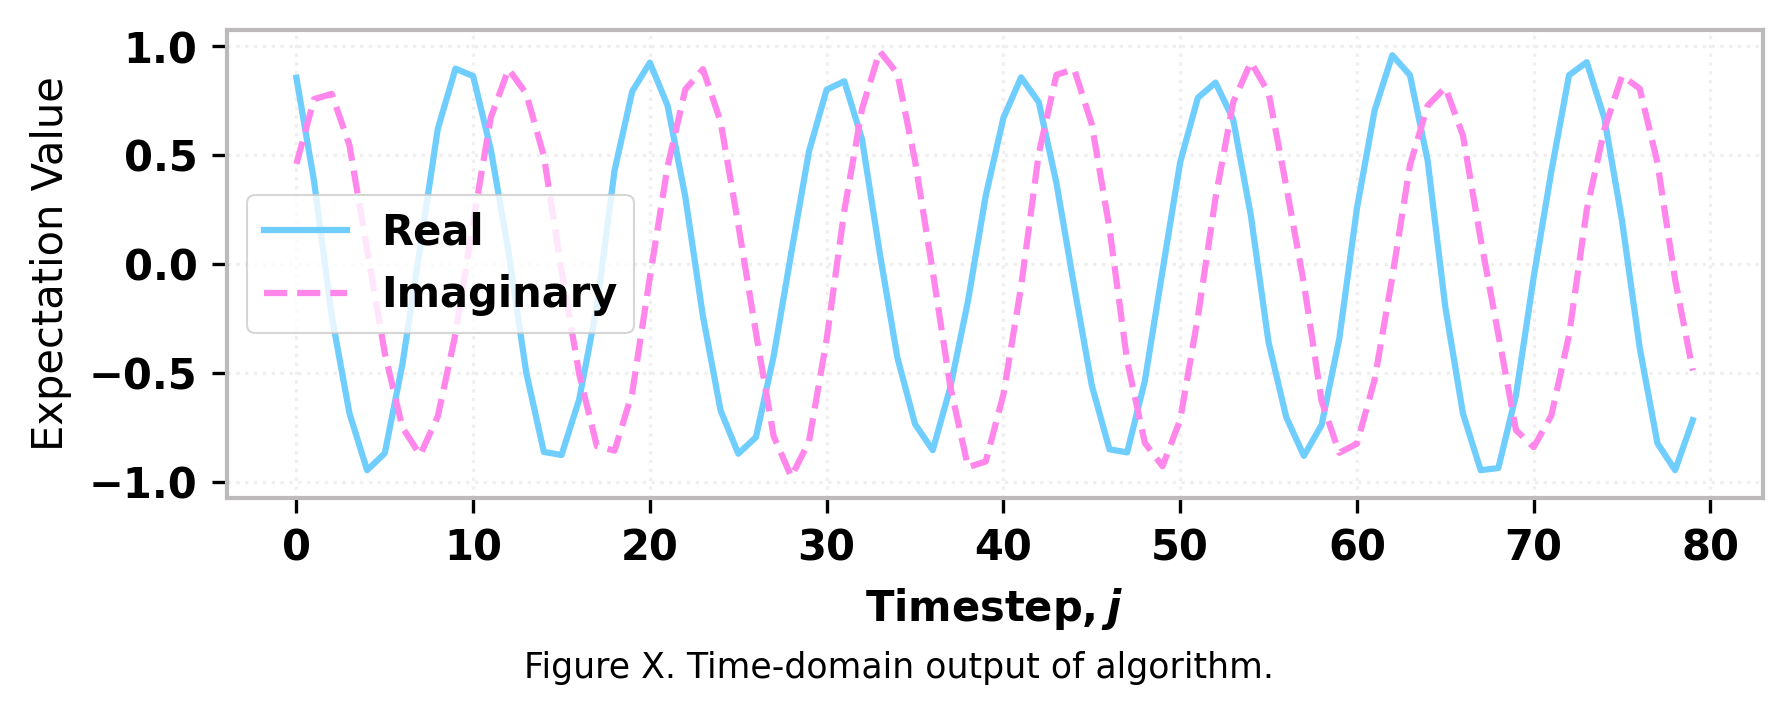

In [33]:
import matplotlib.pyplot as plt
plt.style.use("pennylane.drawer.plot")

fig = plt.figure(figsize=(6.4, 2.4))
ax = fig.add_axes((0.15, 0.3, 0.8, 0.65))  # Leave space for caption.
ax.plot(range(len(expvals[0, :])), expvals[0, :], label="Real")
ax.plot(range(len(expvals[1, :])), expvals[1, :], label="Imaginary", linestyle="--")
ax.set(xlabel=r"$\mathrm{Time step}, j$", ylabel=r"Expectation Value")
fig.text(0.5, 0.05, "Figure X. Time-domain output of algorithm.",
    horizontalalignment="center", size="small", weight="normal")
ax.legend()
plt.show()

We can now Fourier transform the output to determine the spectrum.

In [34]:
L_j = np.exp(-eta * time_interval)
normalized_f_domain_Greens_func = lambda w: tau/(2*np.pi) * (1 + 2*np.sum(L_j * (
                expvals[0,:] * np.cos(time_interval * w)   
                - expvals[1,:] * np.sin(time_interval * w))))

normalized_f_domain_Greens_array = np.array([normalized_f_domain_Greens_func(w) for w in wgrid])

dipole_norm = dip_norm
spectrum = dipole_norm**2 * normalized_f_domain_Greens_array

Since $H_2$ is a simple system and our number of orbitals are small, we can easily calculate a classical spectrum for comparison. We do this using the CISD module that we used to determine the ground state, but instead solve for more states. To do this, we will reuse the `myci` instance we created earlier. We  also calculate the transition density matrix in the molecular orbital basis, $\langle F| \hat m_\rho |I \rangle$. **Explain more what this calculation is.** **Maybe I can just reuse the ao to mo coeff from qml.**

In [35]:
# Use CISD to solve for excited states.
myci.nroots = 10  # Compute the first 10 states.
myci.run(verbose=0)

# Determine the dipole integrals using atomic orbitals from RHF object.
dip_ints_ao = hf.mol.intor('int1e_r_cart', comp=3) # In atomic orbital basis.
mo_coeffs = hf.mo_coeff

# Convert to molecular orbital basis.
dip_ints_mo = np.einsum('ik,xkl,lj->xij', mo_coeffs.T, dip_ints_ao, mo_coeffs)


def makedip(ci_id):
    # Transition density matrix in molecular orbital basis.
    t_dm1 = myci.trans_rdm1(myci.ci[0], myci.ci[ci_id])
    # Transition dipole moments.
    return np.einsum('xij,ji->x', dip_ints_mo, t_dm1)


F_m_Is = np.array([makedip(i) for i in range(len(myci.e_tot))])

spectrum_classical_func = lambda E: (1/np.pi) * np.sum(
        [np.sum(np.abs(F_m_I)**2) * eta / ( (E - e)**2 + eta**2) 
                    for (F_m_I, e) in zip(F_m_Is, myci.e_tot)])

spectrum_classical = np.array([spectrum_classical_func(w) for w in wgrid])

Let's plot and compare the classical and quantum spectra.

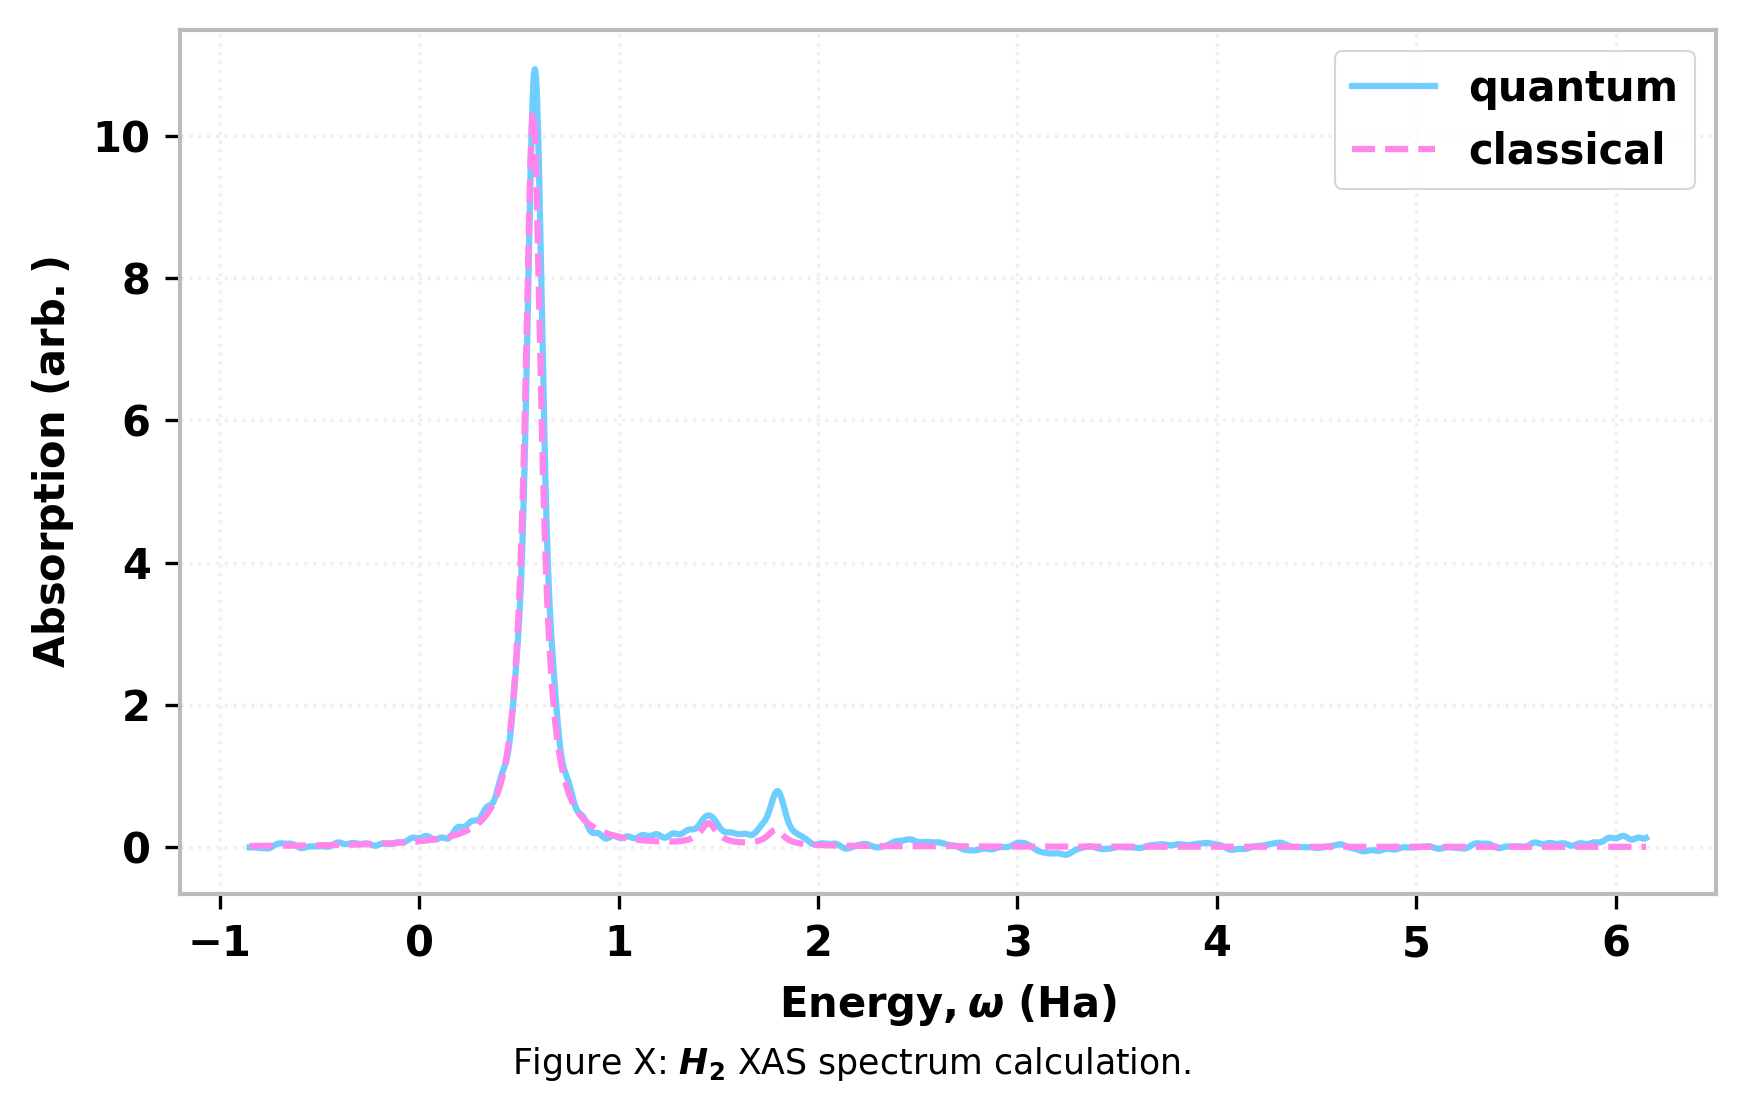

In [36]:
fig = plt.figure(figsize=(6.4, 4))
ax = fig.add_axes((0.15, 0.20, 0.80, 0.72))  # Make room for caption.

ax.plot(wgrid - E_i, spectrum, label='quantum')
ax.plot(wgrid - E_i, spectrum_classical, '--', label='classical')
ax.set_xlabel(r"$\mathrm{Energy}, \omega\ (\mathrm{Ha})$")
ax.set_ylabel(r"$\mathrm{Absorption\ (arb.)}$")
ax.legend()
fig.text(0.5, 0.05, r"Figure X: $H_2$ XAS spectrum calculation.",
        horizontalalignment="center", size="small", weight="normal")

plt.show()

**Describe AO and MO character of the states associated with these absorption peaks (maybe?). They should be the |0> to |2>, |7> and |9> transitions. Is there any physical intuition we can give here?**

## Further Optimizations

**There are more optimizations mentioned in the paper that were not implemented here. Below is a list of further optimizations:**
 - Randomized Trotter steps **(perhaps just provide intuition for why it works, or actually implement it)**
 - BLISS **(this is done in another dmeo, so maybe I'll skip it)**
 - Distribution sampling **(again, maybe just describe)**
 - Core-valence separation approximation
 - Double-measurement scheme. **Perhaps also include the circuit diagram for that implementation.**

**Could implement some of these, show how they could be implemented, or just describe them.** 

**Motivate optimizations by describing difference between interesting systems and the non-complex $H_2$.**

### Core-valence separation approximation

We can restrict the range of frequencies, and consequently the range of final states in our calculation, by only considering final states for which *core* electrons are excited, i.e. there exists a hole in the core orbitals. These are known as core-excited states, and lie significally above the valance-excited states in energy. Typically the frequency range is focused on a target atom in a molecular cluster, and also near a transition energy, such as targetting core $1s$ electrons. We will also neglect relativistic corrections, and focus on frequencies for which the dipole approximation is valid, which is the assumption that the wavelength of the radiation is large compared to the extent of the electronic wavefunction.

Atomic species and oxidations states will determine the energy difference between states with different principle quantum numbers, and this difference will show as a peak in spectroscopy, known as the *absorption edge*. Focusing spctroscopy near this edge for $1s$ to $2p$ is called the $K$-edge, and in general X-ray absorption near-edge spectroscopy is known as XANES. 
<!-- We will focus on simulating spectroscopy in this XANES regime. -->

![alt text](_static/demonstration_assets/xas/core_valence.png)

Figure X: *Core-valence separation.* A much larger amount of energy is required to excite core electrons into valence orbitals compared to electrons already in low-lying valence orbitals. Since XAS targets core electrons, we can ignore valence-excitation matrix elements in our calculations.

## Conclusion
In this tutorial, we have implemented a simplified version of the algorithm as presented in [Fomichev:2025]. The algorithm represents a culmination of many optimizations for time-evolving an electronic Hamiltonian. We've also discussed how XAS is a promising candidate for early fault-tolerant quantum computers due to its low qubit overhead but high amount of correlations in the state space. 

*Acknowledgements*: The author thanks Stepan Fomichev and Pablo A. M. Casares for providing the code used in [Fomichev:2025], which was used as a basis for the simplified implementation demonstrated here.